# Reconstructing bifurcation diagram (Using Autoencoder and SINDy)

In [1]:
import os
import numpy as np
import pickle

### SELECT DATA
from config import MRI8_NVF4_10mm_0p0mmVVVV as cfg

os.chdir('../')
from lib.methods import *

fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

2023-05-01 22:01:51.589643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.chdir('../')

## Load data

In [3]:
csv_data_list, video_data_list, video_t_data_list = LoadCSVandVIDEOS(
                                                                    csv_path=cfg.CSV_FILE_DIR+cfg.DATA_NAME+cfg.CSV_ADDITIONAL_PATH+'.csv', 
                                                                    data_name_list=['t', 'mic', 'flow'], 
                                                                    sample_span=cfg.SAMPLE_SPAN, 
                                                                    videos_path_list=[
                                                                                    cfg.VIDEO_FILE_DIR+'VF/'+cfg.DATA_NAME+'.avi',
                                                                                    cfg.VIDEO_FILE_DIR+'FVF/'+cfg.DATA_NAME+'.avi',
                                                                                    ]
                                                                    )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p0mmVVVV.csv
data list | t, mic, flow
Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/VF/MRI8_NVF4_10mm_0p0mmVVVV.avi


Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/FVF/MRI8_NVF4_10mm_0p0mmVVVV.avi


## Preprocess

In [4]:
pp = PreProcessing(
                data=csv_data_list[1], ### mic data
                t_data=csv_data_list[0], ### mic t data
                video_data_list=video_data_list, 
                video_t_data_list=video_t_data_list
                )
pp.filter()
pp.filter_video(params_list=[cfg.FILTERING_VIDEO_PARAMS_VF, cfg.FILTERING_VIDEO_PARAMS_FVF])
pp.linescanning_video(params_list=[cfg.LINE_SCANNING_PARAMS_VF, cfg.LINE_SCANNING_PARAMS_FVF])
pp.standardize_video()

mic_data = pp.data
mic_t_data = pp.t_data
video_data_list = pp.video_data_list
video_t_list = pp.video_t_data_list

flow_data = csv_data_list[2]
video_vf_data = video_data_list[0]
video_fvf_data = video_data_list[1]
video_t_data = video_t_data_list[0]

## Autoencoder (MLP: Multi Layer Perceptron)

In [5]:
AE_vf = AutoEncoder(data=video_vf_data, 
                    method=cfg.AUTOENCODER_METHOD, 
                    params_mlp=cfg.AUTOENCODER_PARAMS_VF)
### TRAIN MLP
AE_vf.fit(video_vf_data)
### ENCODE
latent_vector_vf = AE_vf.encode(video_vf_data)

2023-05-01 22:32:06.554855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2500/2500 [==============================] - 4s 1ms/step


In [6]:
AE_fvf = AutoEncoder(data=video_fvf_data, 
                    method=cfg.AUTOENCODER_METHOD, 
                    params_mlp=cfg.AUTOENCODER_PARAMS_FVF)
### TRAIN MLP
AE_fvf.fit(video_fvf_data)
### ENCODE
latent_vector_fvf = AE_fvf.encode(video_fvf_data)

2500/2500 [==============================] - 4s 1ms/step


In [8]:
### SAVE
pickle.dump(latent_vector_vf[:, 0], open(cfg.LV_DIR+cfg.DATA_NAME+'_VF.pkl', 'wb'))
pickle.dump(latent_vector_fvf[:, 0], open(cfg.LV_DIR+cfg.DATA_NAME+'_FVF.pkl', 'wb'))

## Bifurcation diagram

In [9]:
### LOAD
latent_vector_vf = pickle.load(open(cfg.LV_DIR+cfg.DATA_NAME+'_vf.pkl', 'rb'))
latent_vector_fvf = pickle.load(open(cfg.LV_DIR+cfg.DATA_NAME+'_fvf.pkl', 'rb'))

In [10]:
### BIFURCATION CONVERT
BC_vf = BifurcationConvert(data=latent_vector_vf, parameter_data=flow_data, t_data=video_t_data)
BC_vf.convert(params = cfg.BF_CONVERT_PARAMS)
BC_vf.discretization(params = cfg.BF_DISCRETIZATION_PARAMS_VF)

### TRAIN DATA
param_lim = cfg.SINDY_PARAM_LIM
bifurcation_parameter_vf_list = BC_vf.bifurcation_parameter_list[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list_discreted = BC_vf.bifurcation_data_list_discreted[param_lim[0]:param_lim[-1]]

sindy_vf = SINDy()
sindy_vf.setup_traindata(bifurcation_data_vf_list_discreted, bifurcation_parameter_vf_list, n_sample=cfg.SINDY_TRAIN_N_SAMPLE_VF)
train_X_vf = sindy_vf.train_X

sparse_list = cfg.SINDY_TRAIN_PARAMS_LIST_VF
train_X_xf_sparse = []
for i in sparse_list:
    train_X_xf_sparse.append(train_X_vf[i])

### TRAIN SINDY
sindy_vf.fit(train_X_xf_sparse, params=cfg.SINDY_PARAMS_VF)
sindy_vf.print_model()
sindy_vf.freerun(data0=cfg.SINDY_FREERUN_PARAMS_VF['data0'], 
                 #parameter_start_stop_step=cfg.SINDY_FREERUN_PARAMS_VF['parameter_start_stop_step'], 
                 parameter_start_stop_step=(0.75, 1.001, 0.00001), 
                 n_run=cfg.SINDY_FREERUN_PARAMS_VF['n_run'], 
                 n_idling_run=cfg.SINDY_FREERUN_PARAMS_VF['n_idling_run'])

### SAVE
pickle.dump(sindy_vf, open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_model_VF.pkl', 'wb'))
pickle.dump(bifurcation_data_vf_list_discreted, open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_data_VF.pkl', 'wb'))
pickle.dump(bifurcation_parameter_vf_list, open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_parameter_VF.pkl', 'wb'))

[ SINDy params ]
order     | 7
threshold | 0.1
alpha     | 0.1
------------------------------
[ SINDy model ]
(x)[k+1] = -410609.047 1 + 17086.897 x[k] + 3384683.899 mu[k] + -12174058.676 mu[k]^2 + -1345.312 x[k]^3 + -90924.497 x[k]^2 mu[k] + 15651.216 x[k] mu[k]^2 + 24375902.208 mu[k]^3 + 392.929 x[k]^4 + 439440.912 x[k]^2 mu[k]^2 + -619122.960 x[k] mu[k]^3 + -28932338.019 mu[k]^4 + -761315.439 x[k]^2 mu[k]^3 + 1515561.684 x[k] mu[k]^4 + 20118603.842 mu[k]^5 + -51.771 x[k]^6 + 411.992 x[k]^4 mu[k]^2 + 574890.921 x[k]^2 mu[k]^4 + -1342544.154 x[k] mu[k]^5 + -7506665.664 mu[k]^6 + -31.208 x[k]^7 + 380.244 x[k]^6 mu[k] + -1433.952 x[k]^5 mu[k]^2 + 2552.581 x[k]^4 mu[k]^3 + -3201.227 x[k]^3 mu[k]^4 + -158532.362 x[k]^2 mu[k]^5 + 411874.098 x[k] mu[k]^6 + 1144742.240 mu[k]^7
(mu)[k+1] = 1.000 mu[k]


In [11]:
### BIFURCATION CONVERT
BC_fvf = BifurcationConvert(data=latent_vector_fvf, parameter_data=flow_data, t_data=video_t_data)
BC_fvf.convert(params = cfg.BF_CONVERT_PARAMS)
BC_fvf.discretization(params = cfg.BF_DISCRETIZATION_PARAMS_FVF)

### TRAIN DATA
param_lim = cfg.SINDY_PARAM_LIM
bifurcation_parameter_fvf_list = BC_fvf.bifurcation_parameter_list[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list_discreted = BC_fvf.bifurcation_data_list_discreted[param_lim[0]:param_lim[-1]]

sindy_fvf = SINDy()
sindy_fvf.setup_traindata(bifurcation_data_fvf_list_discreted, bifurcation_parameter_fvf_list, n_sample=cfg.SINDY_TRAIN_N_SAMPLE_FVF)
train_X_fvf = sindy_fvf.train_X

sparse_list = cfg.SINDY_TRAIN_PARAMS_LIST_FVF
train_X_fxf_sparse = []
for i in sparse_list:
    train_X_fxf_sparse.append(train_X_fvf[i])

### TRAIN SINDY
sindy_fvf.fit(train_X_fxf_sparse, params=cfg.SINDY_PARAMS_FVF)
sindy_fvf.print_model()
sindy_fvf.freerun(data0=cfg.SINDY_FREERUN_PARAMS_FVF['data0'], 
                 #parameter_start_stop_step=cfg.SINDY_FREERUN_PARAMS_FVF['parameter_start_stop_step'], 
                 parameter_start_stop_step=(0.75, 1.001, 0.00001), 
                 n_run=cfg.SINDY_FREERUN_PARAMS_FVF['n_run'], 
                 n_idling_run=cfg.SINDY_FREERUN_PARAMS_FVF['n_idling_run'])

### SAVE
pickle.dump(sindy_fvf, open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_model_FVF.pkl', 'wb'))
pickle.dump(bifurcation_data_fvf_list_discreted, open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_data_FVF.pkl', 'wb'))
pickle.dump(bifurcation_parameter_fvf_list, open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_parameter_FVF.pkl', 'wb'))

[ SINDy params ]
order     | 7
threshold | 0.1
alpha     | 0.1
------------------------------
[ SINDy model ]
(x)[k+1] = -7102.960 1 + 18917.306 mu[k] + 25019.997 x[k] mu[k] + 20447.597 mu[k]^2 + -1338.863 x[k]^2 mu[k] + -141880.221 x[k] mu[k]^2 + -111518.797 mu[k]^3 + 8975.063 x[k]^2 mu[k]^2 + 311484.407 x[k] mu[k]^3 + 111338.573 mu[k]^4 + 405.603 x[k]^4 mu[k] + -3714.500 x[k]^3 mu[k]^2 + -8926.053 x[k]^2 mu[k]^3 + -343791.484 x[k] mu[k]^4 + -239.964 x[k]^6 + 1485.644 x[k]^5 mu[k] + -3757.623 x[k]^4 mu[k]^2 + 8363.244 x[k]^3 mu[k]^3 + 191139.634 x[k] mu[k]^5 + -52494.586 mu[k]^6 + 54.651 x[k]^7 + -206.693 x[k]^6 mu[k] + 774.552 x[k]^4 mu[k]^3 + -2169.699 x[k]^3 mu[k]^4 + -41651.452 x[k] mu[k]^6 + 20388.445 mu[k]^7
(mu)[k+1] = 1.000 mu[k]


## Figure

In [12]:
fig = Figure_BCVVFC({
                    'font.family':'Times New Roman',
                    'mathtext.fontset':'stix',
                    'font.size':30,
                    })

In [13]:
### LOAD
sindy_vf = pickle.load(open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_model_VF.pkl', 'rb'))
bifurcation_data_vf_list_discreted = pickle.load(open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_data_VF.pkl', 'rb'))
bifurcation_parameter_vf_list = pickle.load(open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_parameter_VF.pkl', 'rb'))

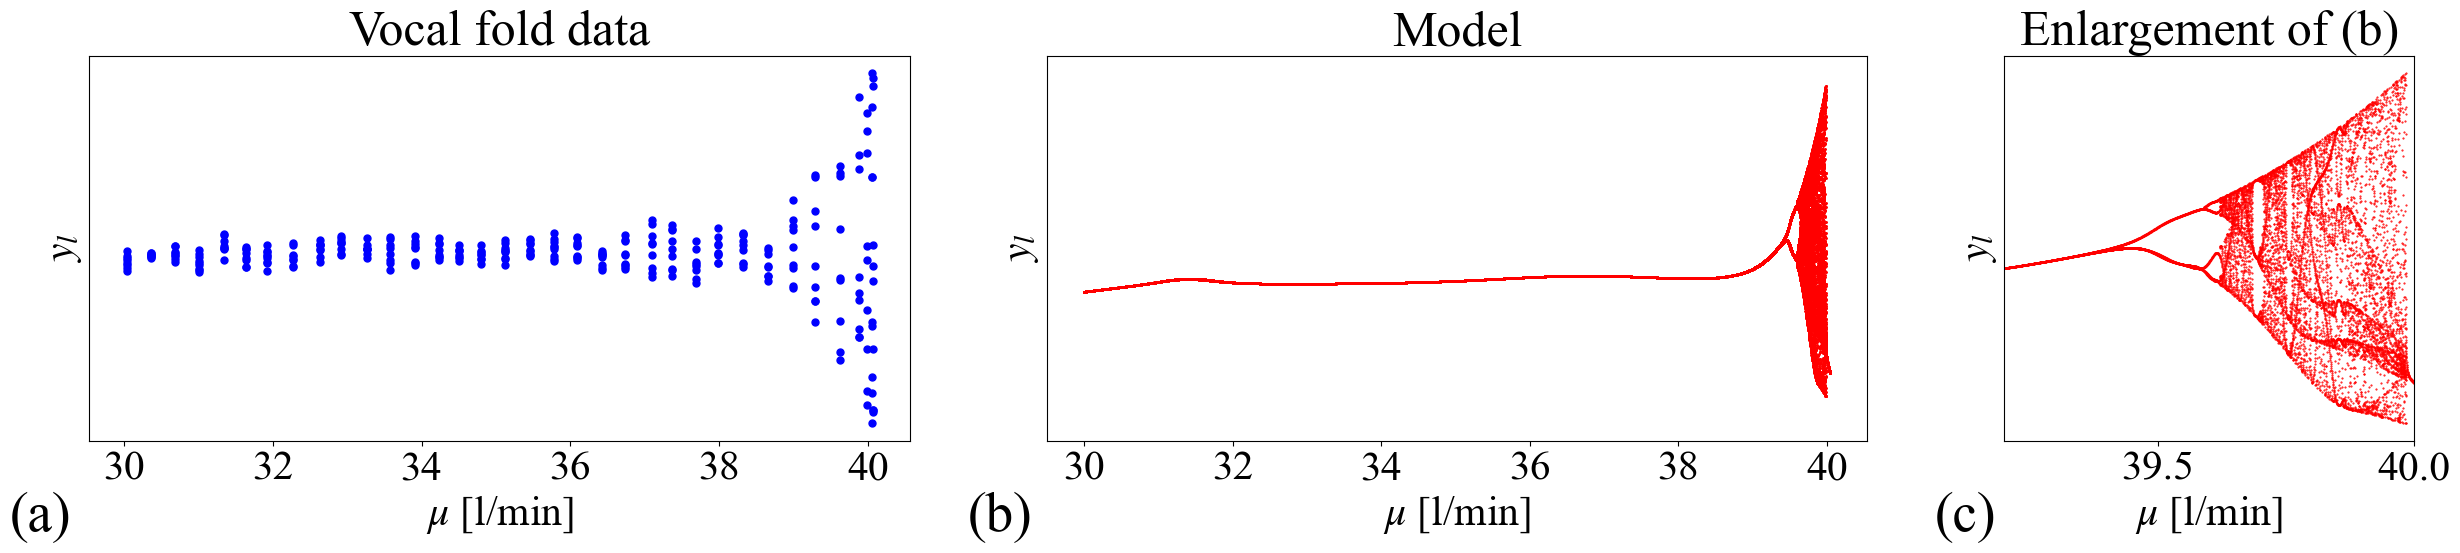

In [14]:
fig.figure06(data1_list=bifurcation_data_vf_list_discreted, data1_parameter_list=bifurcation_parameter_vf_list, 
            data2=sindy_vf.freerun_test_X,
            figsize=(30, 5), width_ratios=[1, 1, 0.5], wspace=0.2,
            title1='Vocal fold data', title2='Model', title3='Enlargement of (b)',
            marker1='.', marker2='.', marker3='.',
            c1='b', c2='r', c3='r', 
            s1=100, s2=5, s3=1,
            xlim1=(None, None), xlim2=(None, None), xlim3=(39.2, 40.00),
            ylim1=(None, None), ylim2=(0.9, 2.4), ylim3=(None, None),
            xlabel1=r'$\mu$'+' [l/min]', xlabel2=r'$\mu$'+' [l/min]', xlabel3=r'$\mu$'+' [l/min]', 
            ylabel1=r'$y_l$', ylabel2=r'$y_l$', ylabel3=r'$y_l$', 
            panel_list = ['(a)', '(b)', '(c)'], panel_xy_list=[(0.3, 0.95), (0.3, 0.95), (0.16, 0.95)], panel_fontsize=40, 
            save_filename='./results/figure/figure06-1.png',)

In [25]:
### LOAD
sindy_fvf = pickle.load(open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_model_FVF.pkl', 'rb'))
bifurcation_data_fvf_list_discreted = pickle.load(open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_data_FVF.pkl', 'rb'))
bifurcation_parameter_fvf_list = pickle.load(open(cfg.SINDY_MODEL_DIR+cfg.DATA_NAME+'_parameter_FVF.pkl', 'rb'))

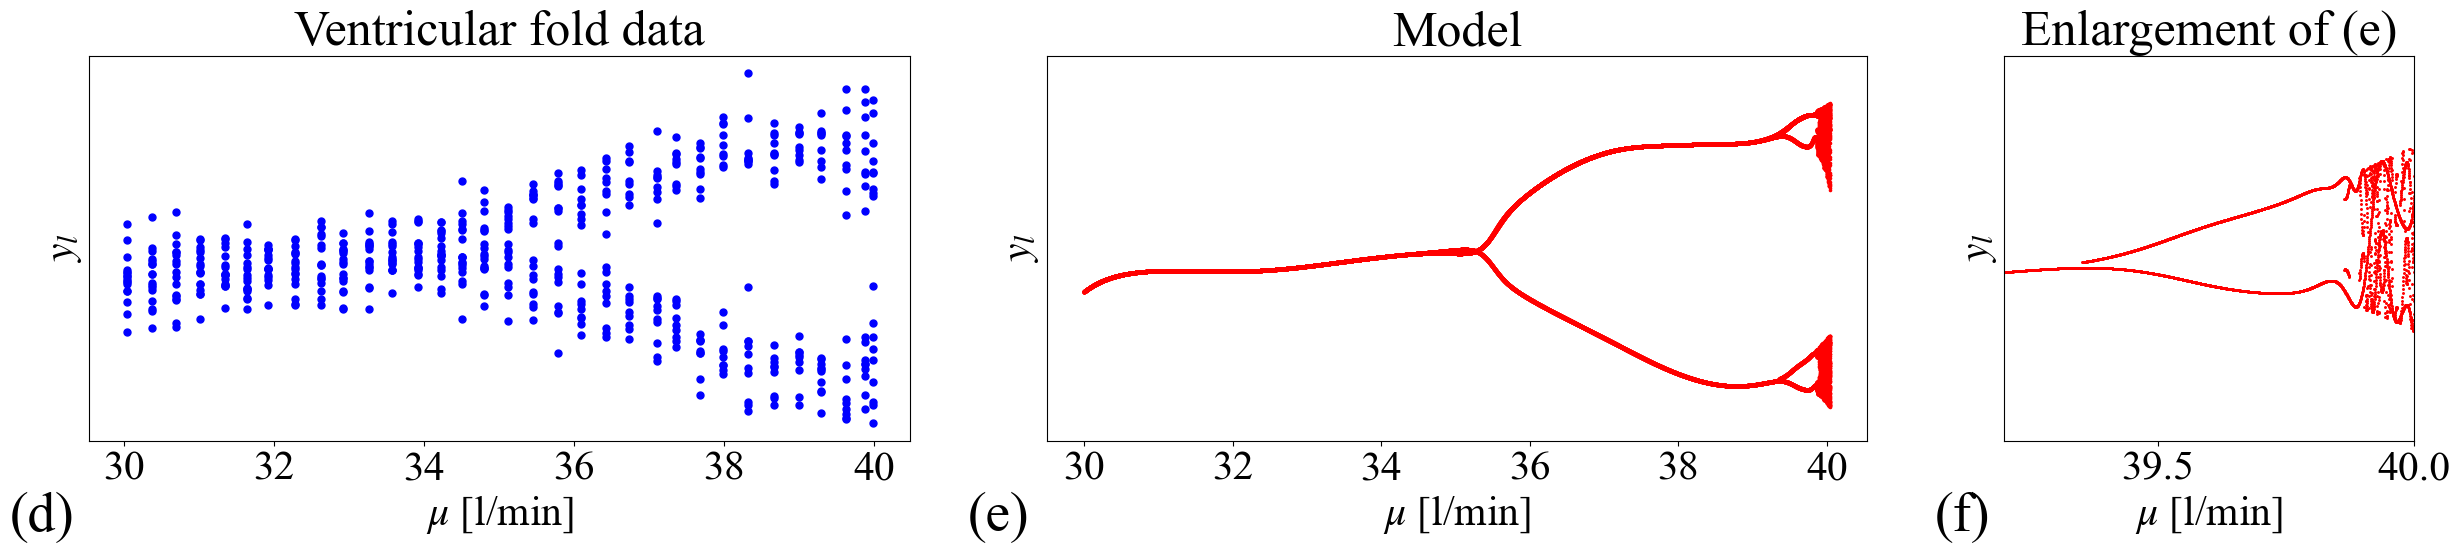

In [93]:
fig.figure06(data1_list=bifurcation_data_fvf_list_discreted[:-2], data1_parameter_list=bifurcation_parameter_fvf_list[:-2], 
            data2=sindy_fvf.freerun_test_X,
            figsize=(30, 5), width_ratios=[1, 1, 0.5], wspace=0.2,
            title1='Ventricular fold data', title2='Model', title3='Enlargement of (e)',
            marker1='.', marker2='.', marker3='.',
            c1='b', c2='r', c3='r', 
            s1=100, s2=10, s3=5,
            xlim1=(None, None), xlim2=(None, None), xlim3=(39.2, 40.00),
            ylim1=(None, None), ylim2=(0.7, 2.0), ylim3=(0.7, 1.15),
            xlabel1=r'$\mu$'+' [l/min]', xlabel2=r'$\mu$'+' [l/min]', xlabel3=r'$\mu$'+' [l/min]', 
            ylabel1=r'$y_l$', ylabel2=r'$y_l$', ylabel3=r'$y_l$', 
            panel_list = ['(d)', '(e)', '(f)'], panel_xy_list=[(0.3, 0.95), (0.3, 0.95), (0.16, 0.95)], panel_fontsize=40, 
            save_filename='./results/figure/figure06-2.png',)